In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sktime.forecasting.arch import ARCH
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. data

In [2]:
TICKER = "BZ=F"
START = "2010-01-01"
END = "2025-06-30"
data = yf.download(TICKER, start=START, end=END, progress=False)
spot = data['Close'][TICKER]
returns = np.log(spot / spot.shift(1)).dropna()
returns.index = pd.PeriodIndex(returns.index, freq='D')
TRAIN_START = START
TRAIN_END = "2023-12-31"
TEST_START = "2024-01-01"
TEST_END = END

train_returns = returns[TRAIN_START:TEST_START]
test_returns = returns[TEST_START:TEST_END]


C:\Users\Szymon.Stolarski\AppData\Local\Temp\ipykernel_23584\4014083244.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START, end=END, progress=False)


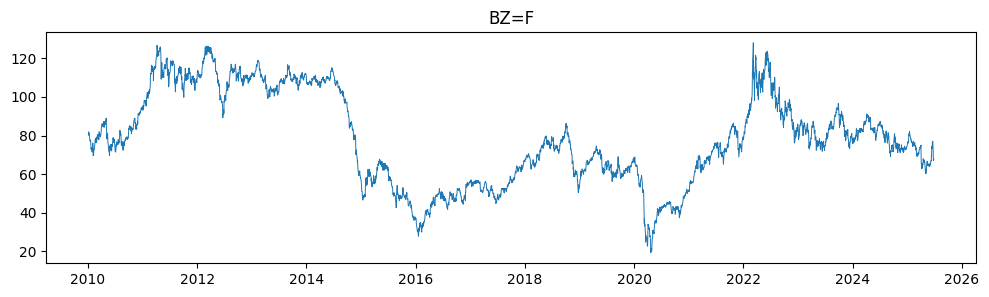

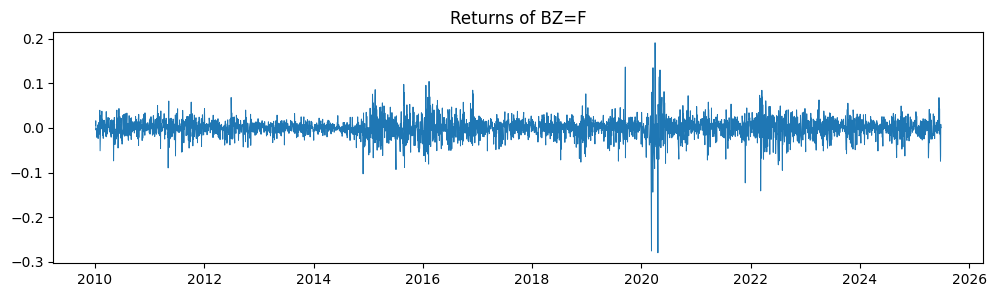

In [3]:
plt.figure(figsize=(12,3))
plt.plot(spot, linewidth=0.7)
plt.title(TICKER)
plt.show()

plt.figure(figsize=(12,3))
plt.plot(returns.index.to_timestamp(), returns.values, label='Daily Returns', linewidth=0.7)
plt.title(f"Returns of {TICKER}")
plt.show()

# 2. Models
## 2.1. GARCH

In [4]:
# Fit ARCH model on returns
forecaster = ARCH(p=1, q=1, mean='Zero', dist="Normal", vol='GARCH', method='analytic', random_state=42, rescale=False)
forecaster.fit(train_returns)
print(forecaster.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   BZ=F   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8784.99
Distribution:                  Normal   AIC:                          -17564.0
Method:            Maximum Likelihood   BIC:                          -17545.5
                                        No. Observations:                 3488
Date:                Sat, Sep 20 2025   Df Residuals:                     3488
Time:                        16:06:07   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0662e-05  6.829e-12  1.561e+06      0.000 [1.

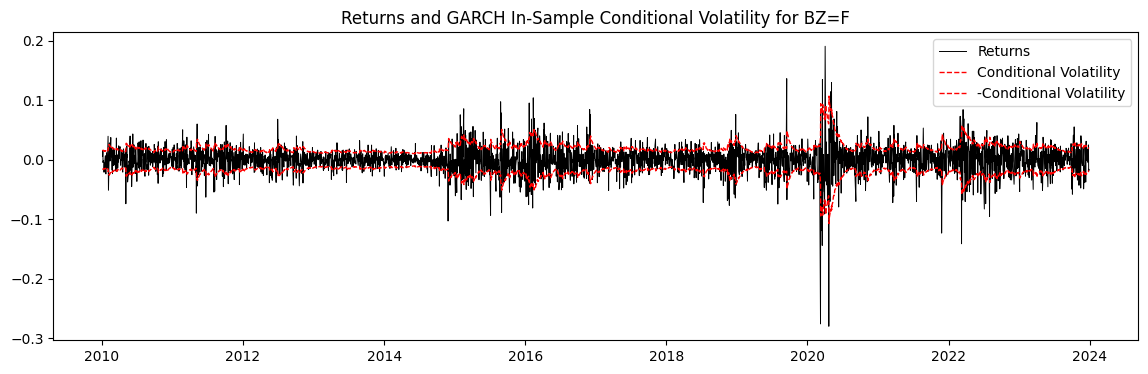

In [5]:
# Get in-sample conditional variance predictions
conditional_volatility_in_sample = forecaster._fitted_forecaster.conditional_volatility
conditional_volatility_in_sample = np.sqrt(forecaster.predict_var(fh=train_returns.index))

plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns', color='black', linewidth=0.7)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), conditional_volatility_in_sample.values, label='Conditional Volatility', color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), -1 * conditional_volatility_in_sample.values, label='-Conditional Volatility', color='red', linestyle='--', linewidth=1)
plt.title(f"Returns and GARCH In-Sample Conditional Volatility for {TICKER}")
plt.legend()
plt.show()

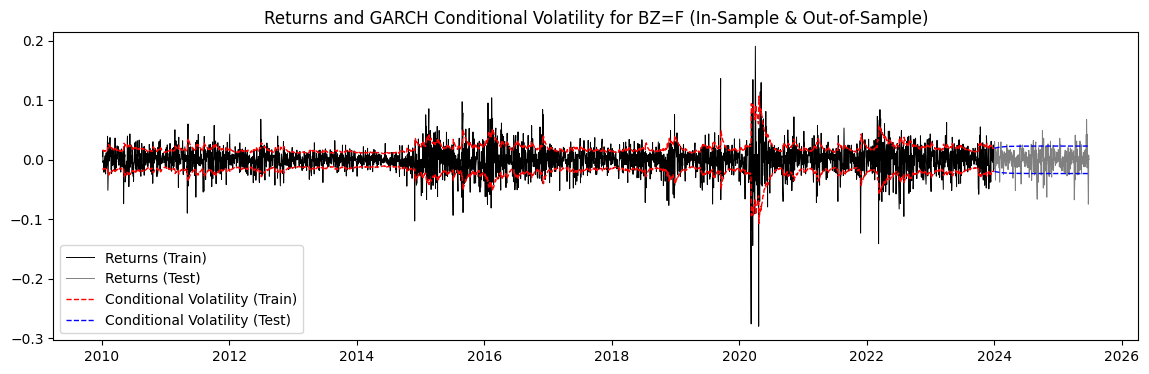

In [6]:
conditional_volatility_out_of_sample = np.sqrt(forecaster.predict_var(fh=test_returns.index))
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), conditional_volatility_in_sample.values, label='Conditional Volatility (Train)', color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), -1 * conditional_volatility_in_sample.values, color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample.index.to_timestamp(), conditional_volatility_out_of_sample.values, label='Conditional Volatility (Test)', color='blue', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample.index.to_timestamp(), -1 * conditional_volatility_out_of_sample.values, color='blue', linestyle='--', linewidth=1)
plt.title(f"Returns and GARCH Conditional Volatility for {TICKER} (In-Sample & Out-of-Sample)")
plt.legend()
plt.show()

In [ ]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_volatility_out_of_sample.loc[test_returns.index]

# Realized volatility: use squared returns as a proxy
realized_vol = np.sqrt(test_returns ** 2)

# Metrics
mse = mean_squared_error(realized_vol, forecast_vol)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realized_vol, forecast_vol)
corr = np.corrcoef(realized_vol, forecast_vol)[0, 1]

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Correlation (Realized vs Forecasted Volatility): {corr:.4f}")

Mean Squared Error (MSE): 0.000236
Root Mean Squared Error (RMSE): 0.015366
Mean Absolute Error (MAE): 0.013270
Correlation (Realized vs Forecasted Volatility): 0.0354


## 2.2. GJR-GARCH

In [8]:
# Fit ARCH model on returns
forecaster = ARCH(p=1, q=1, o=1, mean='Zero', dist="Normal", vol='GARCH', method='analytic', random_state=42, rescale=False)
forecaster.fit(train_returns)
print(forecaster.summary())

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                   BZ=F   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                8805.47
Distribution:                  Normal   AIC:                          -17602.9
Method:            Maximum Likelihood   BIC:                          -17578.3
                                        No. Observations:                 3488
Date:                Sat, Sep 20 2025   Df Residuals:                     3488
Time:                        16:11:58   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0556e-05  8.196e-12  1.288e+06      0.000 [1.

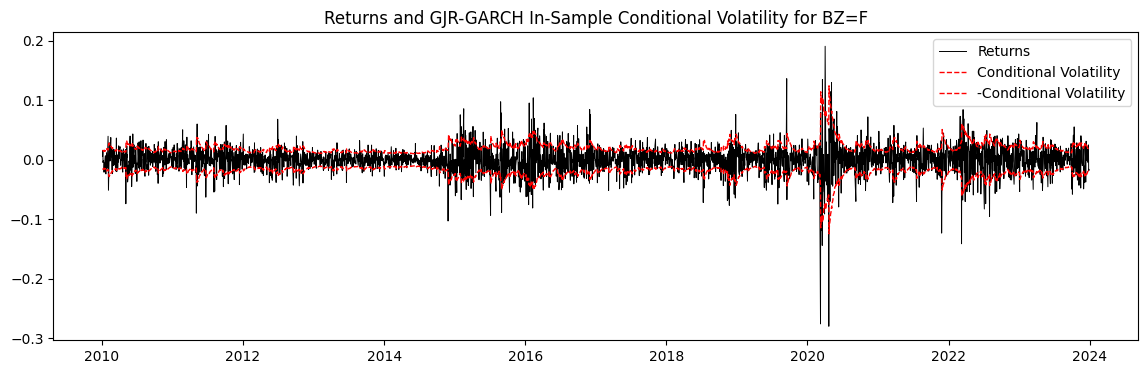

In [9]:
# Get in-sample conditional variance predictions
conditional_volatility_in_sample = forecaster._fitted_forecaster.conditional_volatility
conditional_volatility_in_sample = np.sqrt(forecaster.predict_var(fh=train_returns.index))

plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns', color='black', linewidth=0.7)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), conditional_volatility_in_sample.values, label='Conditional Volatility', color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), -1 * conditional_volatility_in_sample.values, label='-Conditional Volatility', color='red', linestyle='--', linewidth=1)
plt.title(f"Returns and GJR-GARCH In-Sample Conditional Volatility for {TICKER}")
plt.legend()
plt.show()

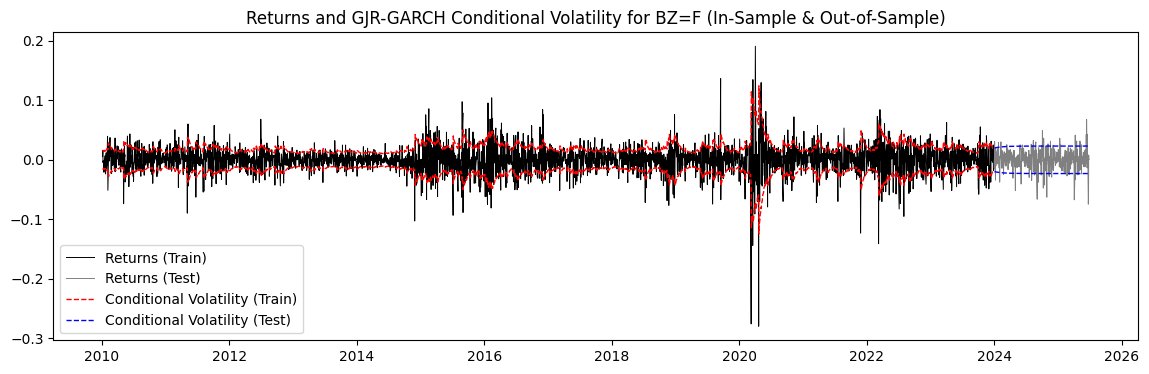

In [11]:
conditional_volatility_out_of_sample = np.sqrt(forecaster.predict_var(fh=test_returns.index))
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), conditional_volatility_in_sample.values, label='Conditional Volatility (Train)', color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_in_sample.index.to_timestamp(), -1 * conditional_volatility_in_sample.values, color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample.index.to_timestamp(), conditional_volatility_out_of_sample.values, label='Conditional Volatility (Test)', color='blue', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample.index.to_timestamp(), -1 * conditional_volatility_out_of_sample.values, color='blue', linestyle='--', linewidth=1)
plt.title(f"Returns and GJR-GARCH Conditional Volatility for {TICKER} (In-Sample & Out-of-Sample)")
plt.legend()
plt.show()

In [12]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_volatility_out_of_sample.loc[test_returns.index]

# Realized volatility: use squared returns as a proxy
realized_vol = np.sqrt(test_returns ** 2)

# Metrics
mse = mean_squared_error(realized_vol, forecast_vol)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realized_vol, forecast_vol)
corr = np.corrcoef(realized_vol, forecast_vol)[0, 1]

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Correlation (Realized vs Forecasted Volatility): {corr:.4f}")

Mean Squared Error (MSE): 0.000237
Root Mean Squared Error (RMSE): 0.015380
Mean Absolute Error (MAE): 0.013289
Correlation (Realized vs Forecasted Volatility): 0.0365
